# Pooled model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [2]:
filepath = '../../../../data/processed/df_filtered_5years_exclude_too_far_islands.xlsx'
df = pd.read_excel(filepath)

df['population_change_rate'] = df.groupby('island_id')['population'].pct_change() * 100
df['log_income'] = np.log(df['income'])
df = df.dropna(subset=['population_change_rate', 'dummy_after_bridge_opened', 'log_income'])

/tmp/ipykernel_20720/1484049911.py:4: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['population_change_rate'] = df.groupby('island_id')['population'].pct_change() * 100


In [3]:
y = df['population_change_rate']
bridge = df['dummy_after_bridge_opened']
income = df['log_income']
islands = dmatrix('C(island_id) -1', data=df, return_type='dataframe')
years = dmatrix('C(year) -1', data=df, return_type='dataframe')

n_islands = islands.shape[1]
n_years = years.shape[1]

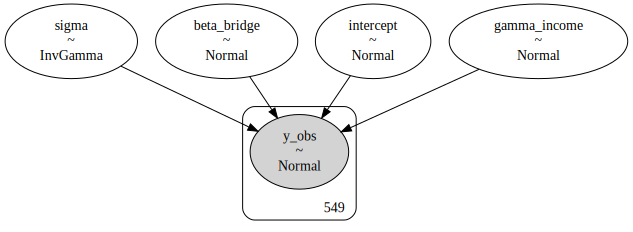

In [5]:
with pm.Model() as model:
    # Priors
    intercept = pm.Normal('intercept', mu=0, sigma=100)
    beta_bridge = pm.Normal('beta_bridge', mu=0, sigma=100)
    gamma_income = pm.Normal('gamma_income', mu=0, sigma=100)
    sigma = pm.InverseGamma('sigma', alpha=0.001, beta=0.001)

    # Link function
    mu = (
        intercept
        + beta_bridge * bridge
        + gamma_income * income
    )

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

# visualize the model
pm.model_to_graphviz(model)

In [7]:
with model:
    idata = pm.sample(
        draws=2000,
        tune=1000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
    )

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

## アウトプットの保存

In [8]:
export_filepath = './sampling_pooled.nc'
az.to_netcdf(idata, export_filepath)

'./sampling_pooled.nc'

## アウトプットのインポート

In [18]:
import_filepath = './sampling_pooled.nc'
idata = az.from_netcdf(import_filepath)

In [19]:
az.summary(idata, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-10.480,3.813,-17.813,-3.150,0.065,0.046,3468.0,3786.0,1.0
beta_bridge,7.059,1.779,3.580,10.595,0.026,0.018,4828.0,4316.0,1.0
gamma_income,-0.434,0.413,-1.264,0.337,0.007,0.005,3533.0,3866.0,1.0
sigma,20.928,0.640,19.696,22.203,0.009,0.006,5004.0,4109.0,1.0


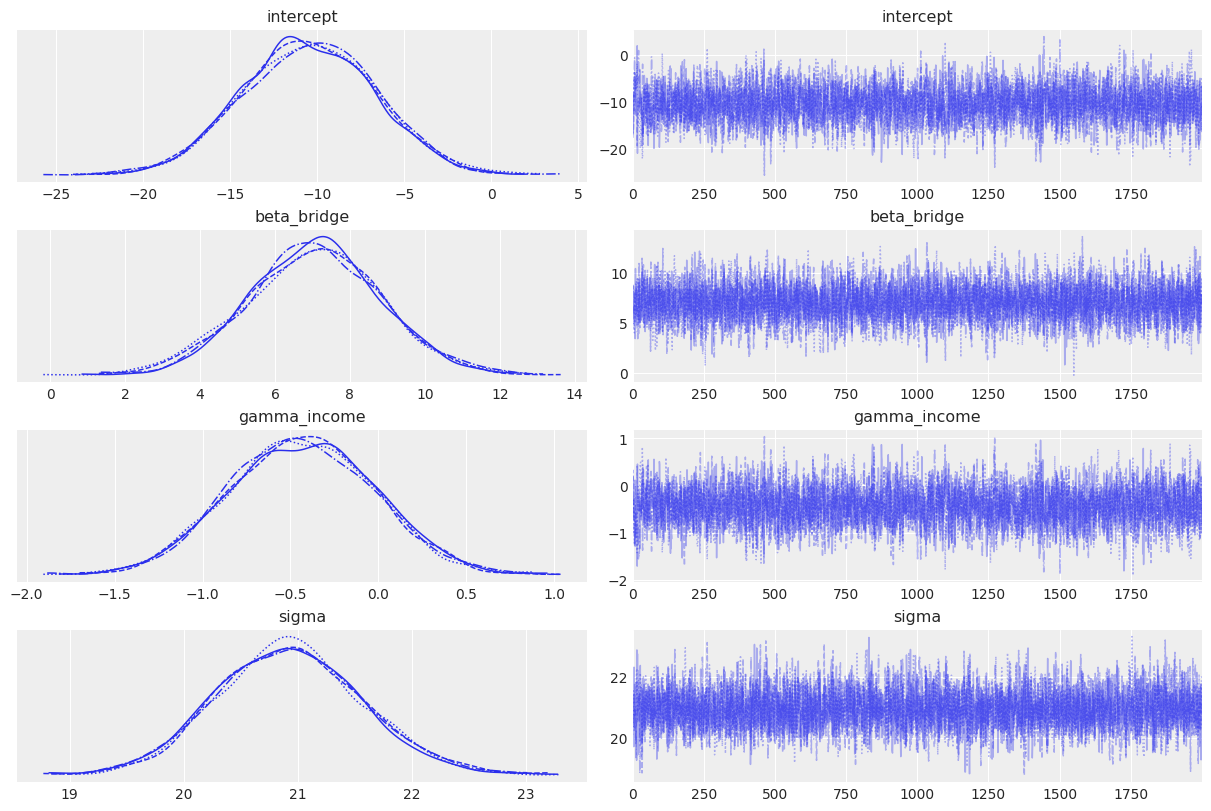

In [11]:
az.plot_trace(idata);

In [14]:
posterior_samples = idata.posterior

# 0以上のサンプルの割合を計算
prob_beta_bridge_positive = np.mean(posterior_samples['beta_bridge'] > 0)
print(f"Pr(beta_bridge > 0) = {prob_beta_bridge_positive:.4f}")
prob_beta_income_positive = np.mean(posterior_samples['gamma_income'] > 0)
print(f"Pr(gamma_income > 0) = {prob_beta_income_positive:.4f}")
prob_sigma_positive = np.mean(posterior_samples['sigma'] > 0)
print(f"Pr(sigma > 0) = {prob_sigma_positive:.4f}")

Pr(beta_bridge > 0) = 0.9999
Pr(gamma_income > 0) = 0.1499
Pr(sigma > 0) = 1.0000


In [20]:
with model:
    pm.compute_log_likelihood(idata)

Output()

In [21]:
loo = az.loo(idata)
loo

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 8000 posterior samples and 549 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2462.03    86.80
p_loo       24.83        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      547   99.6%
   (0.70, 1]   (bad)         1    0.2%
   (1, Inf)   (very bad)    1    0.2%